# Classification in PyTorch

In [1]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 2.3 MB/s 


In [2]:
import numpy as np
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import StratifiedKFold
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize
from skopt.utils import use_named_args
from scipy.optimize.zeros import results_c

## Generating Data: 
Label = 0:
    x1 = rcos(t), x2 = rsin(t)

Label = 1:
    x1 = (r + 5)cos(t) x2 = (r + 5)sin(t)

where r ∼ N(0, 1), t ∼ Uniform[0, 2π)

In [3]:
def generate_data(n):
    r = lambda : np.random.normal(0,1)
    t = lambda : np.random.uniform(0,2*np.pi)
    labels = [1 for _ in range(int(n/2))] + [0 for _ in range(int(n/2))]
    labels = np.array(labels)                                        
    random.shuffle(labels)
    X = []
    for y in labels: 
        theta = t()
        radius = r()
        x1 = (5*y+radius)*np.cos(theta)
        x2 = (5*y+radius)*np.sin(theta)
        X.append((x1,x2))
    X = np.array(X)
    return X, labels


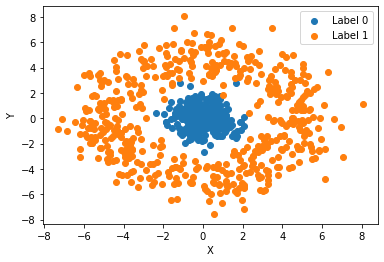

In [4]:
def show_distribution(X,labels):
    pos_index = np.where(labels == 1)
    neg_index = np.where(labels == 0)
    X_ = X.copy()
    positives, negatives = X[pos_index], X_[neg_index]
    plt.scatter(negatives[:,0], negatives[:,1], label = 'Label 0')
    plt.scatter(positives[:,0], positives[:,1], label = 'Label 1')
    plt.legend(), plt.xlabel('X'), plt.ylabel('Y')


x,y = generate_data(1000)
show_distribution(x,y)

## PyTorch Classifier

In [5]:
class Classifier(nn.Module):
    '''
    One layer deep neural network classifier with ReLU activation on hidden
    layer. 
    '''
    def __init__(self,
                 input_channel,
                 hidden_size, 
                 output_channel,
                 activation):
        super(Classifier, self).__init__()
        self.hidden_layer = nn.Linear(input_channel, hidden_size, bias = True)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_channel, bias = True)
        self.activation = activation()
        self.relu_activation = None #values of relu activations

    def forward(self, x):
        x = x.type(torch.FloatTensor)
        x = self.hidden_layer(x)
        x = self.relu(x)
        self.relu_activation = x.data.cpu().numpy()
        x = self.output_layer(x)
        x = self.activation(x)
        return x

## Torch Dataset and Dataloader

In [6]:
class Data(Dataset):
    '''
    Dataset for Torch dataloaders
    '''
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.Y)
    def __getitem__(self,idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x,y

## Training and Validation

In [7]:
def train(model, 
          train_loader,
          val_loader,
          optimizer, 
          scheduler, 
          criterion, 
          epochs = 15,
          logging = True,
          track_activation = False):
    '''
    Train model
    :param model: Initialized PyTorch classifier
    :param train_loader: training set Torch Dataloader
    :param val_loader: validation set Torch Dataloader
    :param optimizer: Weight optimizer (ie: SGD, ADAM)
    :param scheduler: learning rate scheduler
    :param criterion: loss function
    :param epochs: learning epochs
    :param logging: print loss and accuracy over epochs
    :track activation: 
    :return: dict of training and validation loss and accuracy
    '''
    training_history, validation_history = [],[]
    activation_history = []
    for epoch in range(1,epochs+1): 
        model.train()
        predictions, targets, losses = [],[],[]
        activations = []
        for i, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            output = torch.squeeze(output)
            target = target.type(torch.FloatTensor)
            loss = criterion(output, target)
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            #BCE Loss is used, so round result to get prediction. 
            prediction = np.round(output.detach())
            predictions += prediction.squeeze().tolist()
            targets += target.squeeze().tolist()
            if track_activation:
                #Tracking activity of hidden layer
                activations.append(model.relu_activation)
        acc = accuracy_score(y_true=targets, y_pred=predictions)
        mean_loss = np.mean(losses)
        if track_activation:
            activation_history.append(activations)
        if logging:
            print(f'Epoch: {epoch}/{epochs}')
            print(f'\tTraining Accuracy: {acc:.2f} | Loss: {mean_loss:.2f}')
        training_dict = {'accuracy':acc, 'loss':mean_loss}
        #model validation
        validation_dict = eval(model,
                            val_loader,
                            criterion,
                            logging = logging)
        training_history.append(training_dict)
        validation_history.append(validation_dict)
    ret = {'training':training_history,'validation':validation_history}
    if track_activation:
        return ret, activation_history
    else:
        return ret

def eval(model, 
         test_loader,
         criterion,
         validation = True,
         logging = True):
    '''
    Model evaluation
    :param model: Initialized PyTorch classifier
    :param test_loader: test/validation set Torch Dataloader
    :param criterion: loss function
    :param logging: print loss and accuracy
    :return: dict of validation loss and accuracy
    '''
    predictions, targets, losses = [],[],[]
    model.eval()
    with torch.no_grad():
        for i,(data,target) in enumerate(test_loader):
            output = model(data)
            output = torch.squeeze(output)
            target = target.type(torch.FloatTensor)
            loss = criterion(output, target)
            losses.append(loss.item())
            prediction = np.round(output.detach())
            predictions += prediction.squeeze().tolist()
            targets += target.squeeze().tolist()
    acc = accuracy_score(y_true=targets, y_pred=predictions)
    mean_loss = np.mean(losses)
    mode = 'Validation' if validation else 'Testing'
    if logging:
        print(f'\t{mode}: Accuracy: {acc:.2f} | Loss: {mean_loss:.2f}')
    return {'accuracy':acc, 'loss':mean_loss}



def k_fold_cross_validation(model,
                            dataset,
                            criterion,
                            optimizer,
                            scheduler,
                            batch_size = 16,
                            folds = 5,
                            epochs = 15,
                            logging = False,
                            track_activation = False):
    '''
    K fold cross validation. Calls train model. 
    :param model: Initialized PyTorch classifier
    :param dataset: Data Object
    :param optimizer: Weight optimizer (ie: SGD, ADAM)
    :param scheduler: learning rate scheduler
    :param criterion: loss function
    :param folds: number of validation folds
    :param batch_size: batch size for mini-batch optmization
    :param epochs: learning epochs
    :param logging: print loss and accuracy over epochs
    :track activation: 
    :return: dict of training and validation loss and accuracy over folds
    '''
    X,Y = dataset
    skf = StratifiedKFold(n_splits=folds, shuffle=True)
    fold =0
    performance_history, activation_history = [], []
    for train_idx, val_idx in skf.split(X, Y):
        #get fold indices
        x_train, x_val = X[train_idx], X[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]
        training_set = Data(x_train, y_train)
        #create training set and validation set dataloaders for current fold
        train_loader = DataLoader(training_set,
                                batch_size = batch_size,
                                shuffle=True, 
                                num_workers=0)
        val_dataset = Data(x_val, y_val)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size,
                                shuffle=True,
                                num_workers=0)
        fold += 1
        if logging:
            print(f'\nTraining fold {fold}/{folds}')
        performance = train(model, 
                            train_loader,
                            val_loader,
                            optimizer, 
                            scheduler, 
                            criterion, 
                            epochs = epochs,
                            logging = logging,
                            track_activation = track_activation)
        if track_activation:
            performance, tracking = performance
            activation_history.append(tracking)
        performance_history.append(performance)
    if track_activation:
        return performance_history, activation_history
    else:
        return performance_history

## Hyperparameter Optimization
Select your hyperparameters (learning rate, batch size, etc.) to maximize your accuracy. Select an appro- priate loss function and output layer activation for the task.

Hyperparameter search done by Bayesian optimization

In [18]:
def hyperparameter_search(design,
                          search_space, 
                          n_calls = 20,
                          folds = 5,
                          logging = True):
    '''
    Bayesian hyperparameter search. Minimizes (1-acc), 
    where acc in mean accuracy on k cross validation folds. 
    :param design: design dict 
    :param search_space: list of skopt.space variables
    :param n_calls: number of search points
    :param folds: number of k-fold cv 
    :param logging: print loss and accuracy
    :return results: search results
    '''
    activation = design['activation']
    epochs = design['epochs']
    dataset = generate_data(design['data_samples'])

    @use_named_args(dimensions=search_space)
    def evaluate_model(learning_rate,
                       batch_size,
                       weight_decay,
                       gamma,
                       hidden_size): 
                       
        model = Classifier(2,hidden_size,1, activation)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
        criterion = nn.BCELoss()
        scheduler = StepLR(optimizer, step_size = 1, gamma=gamma)
        #perform cross validation with these hyperparameter values
        performance = k_fold_cross_validation(model,
                                            dataset,
                                            criterion,
                                            optimizer,
                                            scheduler,
                                            batch_size = int(batch_size),
                                            folds = folds,
                                            epochs = epochs,
                                            logging = False,
                                            track_activation = False)
        performance = [x['validation'] for x in performance]
        accuracy = np.mean([performance[fold][-1]['accuracy'] for fold in range(len(performance))])
        accuracy = np.mean(accuracy)
        #minimization of 1 - accuracy (on validation set)
        return 1 - accuracy
        
    result = gp_minimize(evaluate_model, 
                         search_space,
                         n_calls = n_calls,
                         n_initial_points = 5)
    results = {
                'best accuracy': 1- result.fun,
                'learning rate': result.x[0],
                'batch size': result.x[1],
                'weight decay': result.x[2],
                'gamma' : result.x[3],
                'hidden size': result.x[4]
            }
    return results

In [19]:
design = {
            'activation' : nn.Sigmoid,
            'epochs' : 5,
            'data_samples': 10000
         }

#hyperparameter search space. 
#note that hidden size is not a hyperparameter, but a design choice. 
#given the low training time, this value will be optimized for. 
search_space = [Real(1e-8, 1e-2, name='learning_rate', prior = 'log-uniform',  transform = 'identity', base = 10), 
            Categorical([8,16,32,64,128], name='batch_size', transform = 'identity'), 
            Real(1e-4, 1e0, name='weight_decay', prior = 'log-uniform',  transform = 'identity'), 
            Real(0, 0.9, name='gamma', prior = 'uniform',  transform = 'identity'),
            Integer(2, 30, name = 'hidden_size', prior='uniform')]




result = hyperparameter_search(design,
                               search_space,
                               n_calls = 50,
                               folds = 5,
                               logging = False)

print(result)

{'best accuracy': 0.9923, 'learning rate': 0.005700266689750082, 'batch size': 128, 'weight decay': 0.0008975620561915593, 'gamma': 0.9, 'hidden size': 16}


### Running Search

In [26]:
learning_rate = result['learning rate']
batch_size = result['batch size']
weight_decay = result['weight decay']
gamma = result['gamma']
hidden_size = result['hidden size']


design = {
            'activation' : nn.Sigmoid,
            'epochs' : 5,
            'data_samples': 10000
         }

dataset = generate_data(design['data_samples'])
model = Classifier(2,hidden_size,1, design['activation'])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
criterion = nn.BCELoss()
scheduler = StepLR(optimizer, step_size = 1, gamma=gamma)



performance = k_fold_cross_validation(model,
                                    dataset,
                                    criterion,
                                    optimizer,
                                    scheduler,
                                    batch_size = 8,
                                    folds = 5,
                                    epochs = design['epochs'],
                                    logging = True,
                                    track_activation = True)


Training fold 1/5
Epoch: 1/5
	Training Accuracy: 0.97 | Loss: 0.10
	Validation: Accuracy: 0.99 | Loss: 0.03
Epoch: 2/5
	Training Accuracy: 0.99 | Loss: 0.03
	Validation: Accuracy: 0.99 | Loss: 0.04
Epoch: 3/5
	Training Accuracy: 0.99 | Loss: 0.03
	Validation: Accuracy: 0.99 | Loss: 0.03
Epoch: 4/5
	Training Accuracy: 0.99 | Loss: 0.03
	Validation: Accuracy: 0.99 | Loss: 0.03
Epoch: 5/5
	Training Accuracy: 0.99 | Loss: 0.03
	Validation: Accuracy: 0.99 | Loss: 0.03

Training fold 2/5
Epoch: 1/5
	Training Accuracy: 0.99 | Loss: 0.03
	Validation: Accuracy: 0.99 | Loss: 0.02
Epoch: 2/5
	Training Accuracy: 0.99 | Loss: 0.03
	Validation: Accuracy: 0.99 | Loss: 0.03
Epoch: 3/5
	Training Accuracy: 0.99 | Loss: 0.03
	Validation: Accuracy: 0.99 | Loss: 0.03
Epoch: 4/5
	Training Accuracy: 0.99 | Loss: 0.03
	Validation: Accuracy: 0.99 | Loss: 0.03
Epoch: 5/5
	Training Accuracy: 0.99 | Loss: 0.03
	Validation: Accuracy: 0.99 | Loss: 0.03

Training fold 3/5
Epoch: 1/5
	Training Accuracy: 0.99 | Loss:

In [27]:
performance, activation = performance

In [28]:
activations = np.array(activation)

In [ ]:
activations.shape

(5, 15, 1000, 8, 11)

In [29]:
activations = np.mean(activations, axis = 0) #average over folds
activations = activations.reshape(activations.shape[0]*activations.shape[1], #flatten over epoch and batch
                                  activations.shape[2], activations.shape[3])
activations = np.mean(activations, axis = 1), #mean over examples in batches

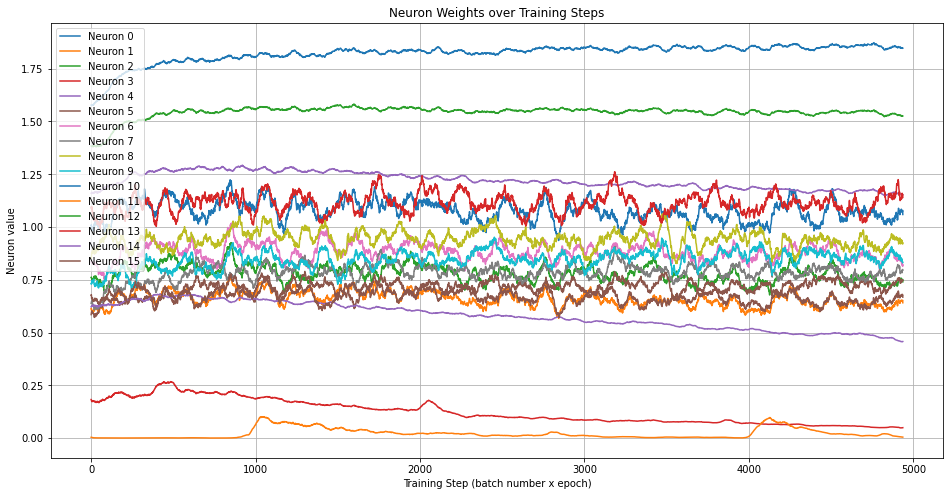

In [30]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

fig = plt.figure(figsize=(16,8))
for i,neuron in enumerate(activations[0].T):
    plt.plot(running_mean(neuron, 64), label= f'Neuron {i}')
plt.xlabel('Training Step (batch number x epoch)')
plt.ylabel('Neuron value'), plt.grid(True)
plt.title('Neuron Weights over Training Steps')
plt.legend()
plt.show()

In [31]:
validation = [x['validation'] for x in performance]
training = [x['training'] for x in performance]
val_acc, val_std = [],[]
train_acc, train_std = [],[]

for epoch in range(len(validation[0])):
    val_accuracy_mean = np.mean([validation[fold][epoch]['accuracy'] for fold in range(len(validation))])
    val_accuracy_std = np.std([validation[fold][epoch]['accuracy'] for fold in range(len(validation))])
    train_accuracy_mean = np.mean([training[fold][epoch]['accuracy'] for fold in range(len(training))])
    train_accuracy_std = np.std([training[fold][epoch]['accuracy'] for fold in range(len(training))])
    train_acc.append(train_accuracy_mean), train_std.append(train_accuracy_std/len(validation))
    val_acc.append(val_accuracy_mean), val_std.append(val_accuracy_std/len(validation))

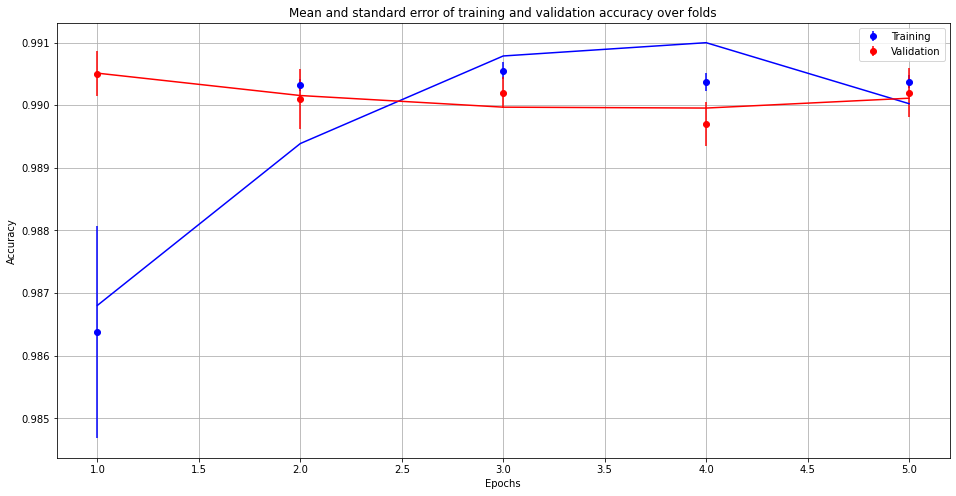

In [35]:
fig = plt.figure(figsize = (16,8))
epochs = np.array([i+1 for i in range(len(train_acc))])
plt.errorbar(epochs, train_acc, yerr=train_std, fmt='o', color='b', label = 'Training')
plt.errorbar(epochs, val_acc, yerr=val_std, fmt='o', color='r', label = 'Validation')

p = np.polyfit(epochs, train_acc, 2)
plt.plot(epochs, np.polyval(p,epochs), color = 'b')
p = np.polyfit(epochs, val_acc, 2)
plt.plot(epochs, np.polyval(p,epochs), color = 'r')
plt.legend(), plt.grid(True)
plt.xlabel('Epochs'), plt.ylabel('Accuracy')
plt.title('Mean and standard error of training and validation accuracy over folds')
plt.show()